In [2]:
from system import *
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
from scipy.integrate import solve_ivp

np.random.seed(232)
x0=np.random.random(2) * 2
x0_2=np.random.random(2)

In [3]:
def add_arrow(line, position=None, direction='right', size=15, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="-|>", color=color),
        size=size
    )

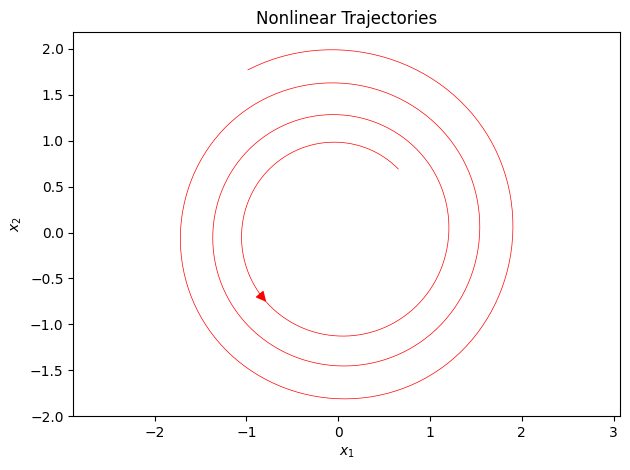

In [5]:
import numpy as np

alpha = 1
c = 0.5

fig, ax = plt.subplots()
steps = 400
x = np.zeros((steps,2))
X0 = [x0]
W = weight_matrix
theta = bias_matrix
alpha = 10
phi = lambda x: alpha * np.tanh(x)
f = lambda x: 1 / tau * (-x + phi(W@x + theta))
dt = 0.05


for x0 in X0:
    x[0] = np.array(x0)
    for i in range(1, steps):
        x[i] = f(x[i - 1]) * dt + x[i - 1]
    l, = ax.plot(x[:, 0], x[:, 1], color = 'red', lw=0.5)
    # add_arrow(l, position=x[20][0])
    add_arrow(l, position=x[60][0])

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_aspect('equal', adjustable='datalim')
ax.set_title('Nonlinear Trajectories')

fig.tight_layout()
# plt.show()
plt.savefig('s2q5.jpeg', dpi=700)

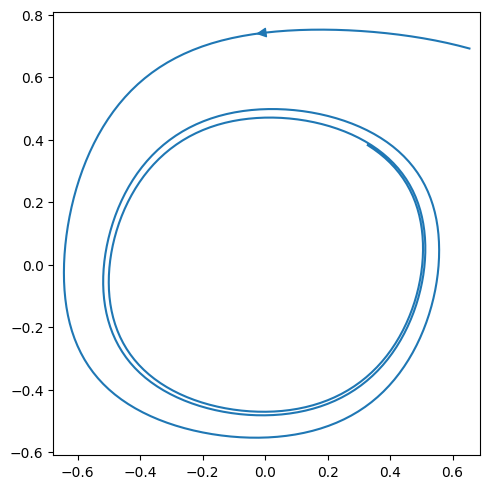

In [9]:
%matplotlib inline
fig, ax = plt.subplots()

W = weight_matrix
theta = bias_matrix
alpha = 10
phi = lambda x: alpha * np.tanh(x)
f = lambda t, x: 1 / tau * (-x + phi(W@x + theta))

t_eval = np.arange(0, 20, 0.05)
sol = solve_ivp(f, t_span=[0, 20], y0=x0, t_eval=t_eval)

l, = ax.plot(sol.y[0], sol.y[1], label='x(t)')
ax.set_aspect('equal', adjustable='datalim')
add_arrow(l)

fig.set_size_inches((5, 5))
plt.tight_layout()
plt.savefig('p1.jpeg', dpi=500)

# Picard Iterations

In [109]:
def integrate(func, x, a, b, axis=0, dt=0.001):
    if a == b:
        return np.zeros(x.shape[1])
    t = np.linspace(a, b, num=x.shape[0])
    fs = func(x, t)
    return np.trapz(fs, dx=dt, axis=0)


def picard_iter(x, f, T, x0, t0=0, dt=0.01):
    x1 = x0 + np.array([integrate(lambda x, s: f(x, s, tf), x[:i], T[0], tf, dt=dt) for i, tf in enumerate(T)]) #integrate(lambda t: f(x0, t), t0, T)
    return x1

def picard_solve(f, T, x0, verbose=False, thresh=10**(-9), dt=0.01):
    xlast = x0
    xcurr = -np.inf
    xsols = []
    i = 0
    picard_dists = []
    while True:
        xcurr = picard_iter(xlast, f, T, x0, dt)
        xsols.append(xcurr.copy())
        picard_dists.append(np.linalg.norm(xlast - xcurr) )
        if verbose: print(picard_dists[-1])
        if picard_dists[-1] < thresh:
            break
        xlast = xcurr.copy()
        i += 1
        
    return xsols

phi = lambda x: np.tanh(x)
f = lambda x, s, t: 1 / tau * (-x + phi(np.array([W@v + theta for v in x]))) 

DT = 0.01
t0, tfinal = 0, 20
T = np.linspace(t0, tfinal, num=int((tfinal - t0) / DT))
NEURONS = W.shape[0]
x_init = np.zeros((T.shape[0], NEURONS)) + np.array([x0])

xsols = picard_solve(f, T, x_init, dt=DT, verbose=True)
    
PER_ROW = NEURONS
fig, axs = plt.subplots(nrows=np.ceil(NEURONS / PER_ROW).astype(int), ncols=PER_ROW)
axs = axs.flatten()
for n in range(NEURONS):
    for i, x in enumerate(xsols):
        style = None
        lw = (i+1)/(len(xsols) + 1)
        if lw < 1:
            style = 'dashed'
        axs[n].plot(T, x[:,n], color='red', lw=lw, linestyle=style)
        axs[n].set_xlabel('Time')
        axs[n].set_ylabel('Activation')
        axs[n].set_title(f'Neuron {n+1}')
        axs[n].set_ylim((-2, 2))
fig.set_size_inches((10, 5))
fig.tight_layout()
plt.show()

if NEURONS == 2 and plot2D:
    fig, ax = plt.subplots()
    l, = ax.plot(xsols[-1][:, 0], xsols[-1][:, 1])
    add_arrow(l)
    fig.set_size_inches((5, 5))
    fig.tight_layout()
    plt.show()

376.064733942951
2807.285781422422


KeyboardInterrupt: 

# Lipschitz

[0.00318902 0.00142959]
1.624247720761206
1.6242263887427755


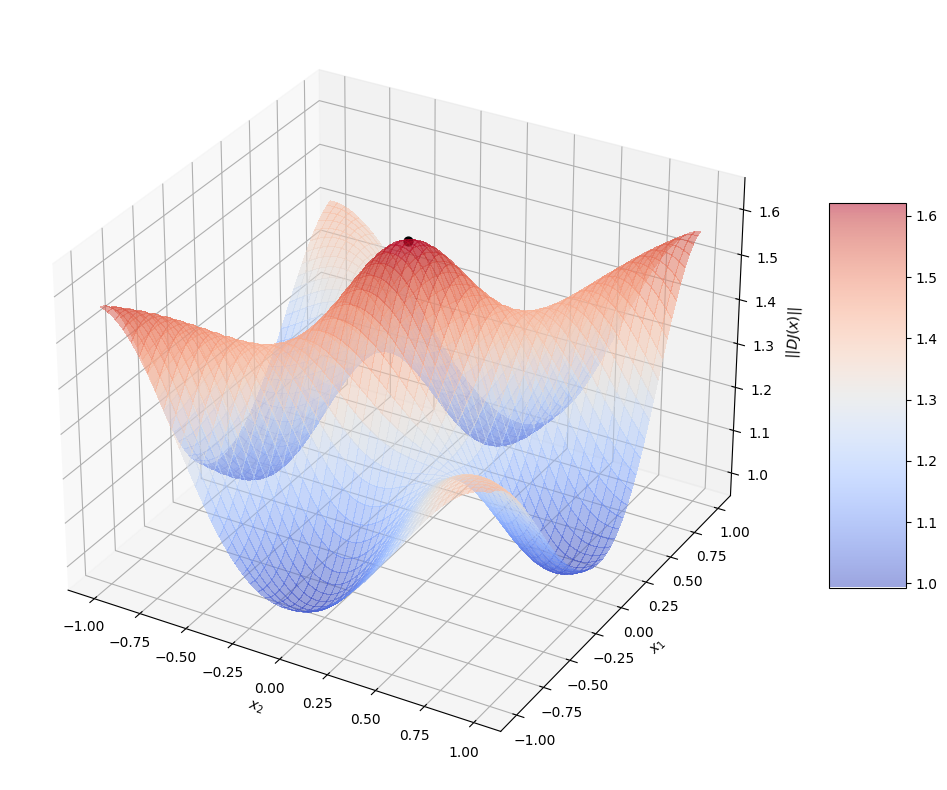

In [110]:
from system import weight_matrix, bias_matrix
import autograd.numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from autograd import jacobian
import matplotlib.pyplot as plt
from matplotlib import cm



np.random.seed(232) #3 #232: BFGS #134: COBYLA
tau = 1.0
NEURONS = 2
# W = np.eye(NEURONS)
# x0 = np.ones(NEURONS) * np.random.random()
x_init = np.zeros(NEURONS)
W = weight_matrix
theta = bias_matrix
phi = lambda x: np.tanh(x)
f = lambda x: 1 / tau * (-x + phi(W@x + theta))

jacobian_cost = jacobian(f)
def func(x):
    global jacobian_cost
    return -np.linalg.norm(jacobian_cost(x))

res = scipy.optimize.minimize(
    fun=func,
    x0=x_init,
    method='SLSQP'
)
x_min = res.x
print(x_min)
print(-func(x_min))
L = -func(x_min)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
dt = 0.01
X = np.arange(-1, 1, dt)
Y = np.arange(-1, 1, dt)
R = np.sqrt(X**2 + Y**2)
# Z = np.sin(R)
# print(Z)
Z = np.zeros((X.shape[0], Y.shape[0]))
for i, x in enumerate(X):
    print(f'{i / len(X) * 100:.2f}%', end='\r')
    for j, y in enumerate(Y):
        v = np.array([x,y])
        Z[i,j] = -func(v)
        # if np.linalg.norm(x_min - v) < 0.5:
        #     print(f'({x}, {y})', Z[i,j])
X, Y = np.meshgrid(X, Y)
print(np.max(Z))
ax.scatter(*x_min[::-1], -func(x_min), color='black', s=40)
# Plot the surface.
cmap = cm.coolwarm
cmap = cmap(np.arange(cmap.N))
cmap[:,-1] = 0.5
from matplotlib.colors import ListedColormap

cmap = ListedColormap(cmap)

surf = ax.plot_surface(X, Y, Z, cmap=cmap,
                    linewidth=0, antialiased=False)


ax.set_xlabel('$x_2$')
ax.set_ylabel('$x_1$')
ax.set_zlabel('$||DJ(x)||$')
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
fig.set_size_inches((10,8))
fig.tight_layout()
plt.show()

In [11]:
np.ones((10,2)) + np.random.random((1,2))

array([[1.49572883, 1.27083161],
       [1.49572883, 1.27083161],
       [1.49572883, 1.27083161],
       [1.49572883, 1.27083161],
       [1.49572883, 1.27083161],
       [1.49572883, 1.27083161],
       [1.49572883, 1.27083161],
       [1.49572883, 1.27083161],
       [1.49572883, 1.27083161],
       [1.49572883, 1.27083161]])

In [23]:
np.random.random((2))

array([0.42610582, 0.21145819])

# PERTURBATIONS

parameter

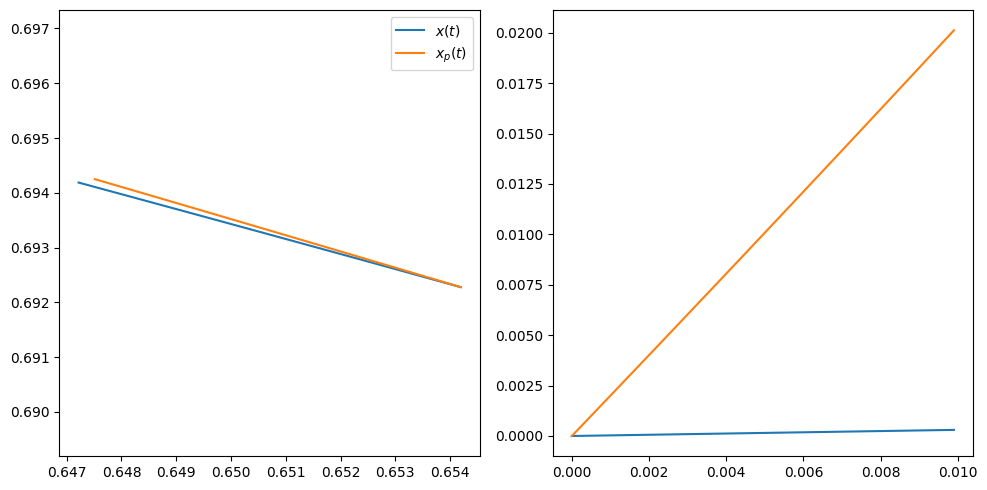

In [123]:
%matplotlib inline
fig, (ax, bx) = plt.subplots(ncols=2)

W = weight_matrix
theta = bias_matrix
pert = 0.03
phi = lambda x: np.tanh(x)
f = lambda t, x: 1 / tau * (-x + phi(W@x + theta))
f_pert = lambda t, x: 1 / tau * (-x + phi(W@x + theta + pert))

tfinal = 0.01
t_eval = np.arange(0, tfinal, 0.0001)
sol = solve_ivp(f, t_span=[0, tfinal], y0=x0, t_eval=t_eval)
sol_pert = solve_ivp(f_pert, t_span=[0, tfinal], y0=x0, t_eval=t_eval)

l, = ax.plot(sol.y[0], sol.y[1], label='$x(t)$')
l, = ax.plot(sol_pert.y[0], sol_pert.y[1], label='$x_p(t)$')
ax.legend()
ax.set_aspect('equal', adjustable='datalim')
# add_arrow(l)

bx.plot(t_eval, np.linalg.norm(sol.y - sol_pert.y, axis=0))
bx.plot(t_eval, 2 * (t_eval) * np.exp(L*t_eval))

fig.set_size_inches((10, 5))
fig.tight_layout()
plt.savefig('p1.jpeg', dpi=500)

initial conditions

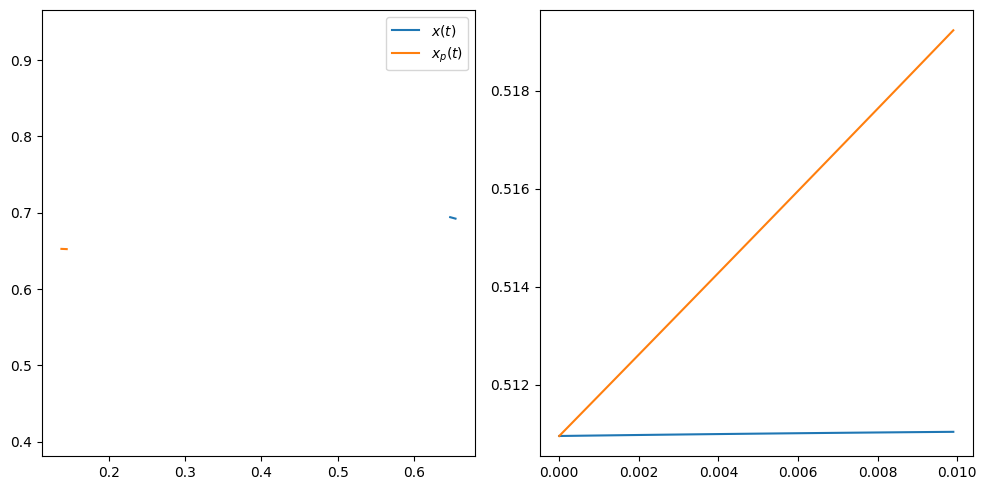

In [124]:
%matplotlib inline
fig, (ax, bx) = plt.subplots(ncols=2)


W = weight_matrix
theta = bias_matrix
phi = lambda x: np.tanh(x)
f = lambda t, x: 1 / tau * (-x + phi(W@x + theta))
f_pert = lambda t, x: 1 / tau * (-x + phi(W@x + theta))

tfinal = 0.01
t_eval = np.arange(0, tfinal, 0.0001)
sol = solve_ivp(f, t_span=[0, tfinal], y0=x0, t_eval=t_eval)
sol_pert = solve_ivp(f, t_span=[0, tfinal], y0=x0_2, t_eval=t_eval)

l, = ax.plot(sol.y[0], sol.y[1], label='$x(t)$')
l, = ax.plot(sol_pert.y[0], sol_pert.y[1], label='$x_p(t)$')
ax.legend()
ax.set_aspect('equal', adjustable='datalim')
# add_arrow(l)

bx.plot(t_eval, np.linalg.norm(sol.y - sol_pert.y, axis=0))
bx.plot(t_eval, np.linalg.norm(x0 - x0_2) * np.exp(L*t_eval))

fig.set_size_inches((10, 5))
fig.tight_layout()
plt.savefig('p1.jpeg', dpi=500)

In [104]:
np.random.random()

0.3461387204690489

In [86]:
t_eval

array([0.    , 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007,
       0.0008, 0.0009, 0.001 , 0.0011, 0.0012, 0.0013, 0.0014, 0.0015,
       0.0016, 0.0017, 0.0018, 0.0019, 0.002 , 0.0021, 0.0022, 0.0023,
       0.0024, 0.0025, 0.0026, 0.0027, 0.0028, 0.0029, 0.003 , 0.0031,
       0.0032, 0.0033, 0.0034, 0.0035, 0.0036, 0.0037, 0.0038, 0.0039,
       0.004 , 0.0041, 0.0042, 0.0043, 0.0044, 0.0045, 0.0046, 0.0047,
       0.0048, 0.0049, 0.005 , 0.0051, 0.0052, 0.0053, 0.0054, 0.0055,
       0.0056, 0.0057, 0.0058, 0.0059, 0.006 , 0.0061, 0.0062, 0.0063,
       0.0064, 0.0065, 0.0066, 0.0067, 0.0068, 0.0069, 0.007 , 0.0071,
       0.0072, 0.0073, 0.0074, 0.0075, 0.0076, 0.0077, 0.0078, 0.0079,
       0.008 , 0.0081, 0.0082, 0.0083, 0.0084, 0.0085, 0.0086, 0.0087,
       0.0088, 0.0089, 0.009 , 0.0091, 0.0092, 0.0093, 0.0094, 0.0095,
       0.0096, 0.0097, 0.0098, 0.0099])